Bank marketing dateset taken from UCI  
Link : https://archive.ics.uci.edu/dataset/222/bank+marketing  


The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 
The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).



In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


In [2]:
#loading dataset
df = pd.read_csv('bank-additional-full.csv', delimiter=';')
#dropping columns that might be less related to desired output
drop_columns = [ 'duration','emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
#rename columns for better understanding
df = df.rename(columns={'job': 'job_type', 'default': 'default_status',
                                                   'housing': 'housing_loan_status', 'loan': 'personal_loan_status',
                                                   'contact': 'contact_type', 'month': 'contact_month',
                                                   'day_of_week': 'contact_day_of_week', 'campaign': 'num_contacts',
                                                   'pdays': 'days_last_contact', 'previous': 'previous_contacts',
                                                   'poutcome': 'previous_outcome',
                                                   'y': 'result'
                                                    })
# Drop the specified columns
df = df.drop(columns=drop_columns, errors='ignore')
#convert target to numerical values
#specify the column and map its distinct values to numerical values
df['result'] = df['result'].map({'yes':1, 'no':0})

Lets look at the dataset now

In [3]:
df.head()

,age,job_type,marital,education,default_status,housing_loan_status,personal_loan_status,contact_type,contact_month,contact_day_of_week,num_contacts,days_last_contact,previous_contacts,previous_outcome,result
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   age                   41188 non-null  int64 
 1   job_type              41188 non-null  object
 2   marital               41188 non-null  object
 3   education             41188 non-null  object
 4   default_status        41188 non-null  object
 5   housing_loan_status   41188 non-null  object
 6   personal_loan_status  41188 non-null  object
 7   contact_type          41188 non-null  object
 8   contact_month         41188 non-null  object
 9   contact_day_of_week   41188 non-null  object
 10  num_contacts          41188 non-null  int64 
 11  days_last_contact     41188 non-null  int64 
 12  previous_contacts     41188 non-null  int64 
 13  previous_outcome      41188 non-null  object
 14  result                41188 non-null  int64 
dtypes: int64(5), object(10)
memory usage

In [5]:
df['result'].value_counts()

result
0    36548
1     4640
Name: count, dtype: int64

Train test split

In [6]:
X = df.drop(columns=['result'])
y = df['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

Pipeline

In [7]:
estimators = [
    ('encoder', TargetEncoder()),
    ('clf', XGBClassifier(random_state=8)) # can customize objective function with the objective parameter
]
pipe = Pipeline(steps=estimators)
pipe

,steps,"[('encoder', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,verbose,0
,cols,None
,drop_invariant,False
,return_df,True
,handle_missing,'value'
,handle_unknown,'value'
,min_samples_leaf,20


Hyper Parameter Tuning

In [8]:
search_space = {#within the estimator calling the parameters, Clf is the name of the classifier 
#    previously defined in the pipeline
    'clf__max_depth': Integer(2,8),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode' : Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0)
}
#Note: The search space can be customized based on the specific needs of the model and the dataset.
#BayesSearchCV is used for hyperparameter tuning using Bayesian optimization
#It allows for efficient exploration of the hyperparameter space.
#bayes_search requirese pipeline and search space to be defined
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=search_space,
    n_iter=30,
    scoring='roc_auc',               
    cv=3,
    n_jobs=-1,
    random_state=8,
    verbose=2,
    return_train_score=True,
    #is_classifier=True
)


Train the XGBoost model

In [9]:
opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END clf__colsample_bylevel=0.5331080642783614, clf__colsample_bynode=0.7262320733948379, clf__colsample_bytree=0.5362052518135637, clf__gamma=7.436578137661654, clf__learning_rate=0.0011002938624638172, clf__max_depth=5, clf__reg_alpha=5.016505750780453, clf__reg_lambda=1.964788283871643, clf__subsample=0.5258638996089925; total time=   0.4s
[CV] END clf__colsample_bylevel=0.5331080642783614, clf__colsample_bynode=0.7262320733948379, clf__colsample_bytree=0.5362052518135637, clf__gamma=7.436578137661654, clf__learning_rate=0.0011002938624638172, clf__max_depth=5, clf__reg_alpha=5.016505750780453, clf__reg_lambda=1.964788283871643, clf__subsample=0.5258638996089925; total time=   0.4s
[CV] END clf__colsample_bylevel=0.5331080642783614, clf__colsample_bynode=0.7262320733948379, clf__colsample_bytree=0.5362052518135637, clf__gamma=7.436578137661654, clf__learning_rate=0.0011002938624638172, clf__max_depth=5, clf__reg_alpha=5.

,estimator,"Pipeline(step...=None, ...))])"
,search_spaces,"{'clf__colsample_bylevel': Real(low=0.5,...m='normalize'), 'clf__colsample_bynode': Real(low=0.5,...m='normalize'), 'clf__colsample_bytree': Real(low=0.5,...m='normalize'), 'clf__gamma': Real(low=0.0,...m='normalize'), ...}"
,optimizer_kwargs,None
,n_iter,30
,scoring,'roc_auc'
,fit_params,None
,n_jobs,-1
,n_points,1
,iid,'deprecated'
,refit,True
,cv,3


Evaluation and prediciton

In [10]:
opt.best_estimator_

,steps,"[('encoder', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,verbose,0
,cols,"['job_type', 'marital', ...]"
,drop_invariant,False
,return_df,True
,handle_missing,'value'
,handle_unknown,'value'
,min_samples_leaf,20


In [11]:
opt.best_score_

np.float64(0.7760446966697848)

In [12]:
opt.score(X_test, y_test)

0.7609064484773256

In [13]:
opt.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], shape=(8238,))

In [14]:
opt.predict_proba(X_test)

array([[0.9707873 , 0.02921269],
       [0.909715  , 0.09028501],
       [0.8761    , 0.12390002],
       ...,
       [0.93365276, 0.06634723],
       [0.8354016 , 0.16459839],
       [0.93391794, 0.06608208]], shape=(8238, 2), dtype=float32)

Measuring Feature importance

It plots the factors that contriubuted most.

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

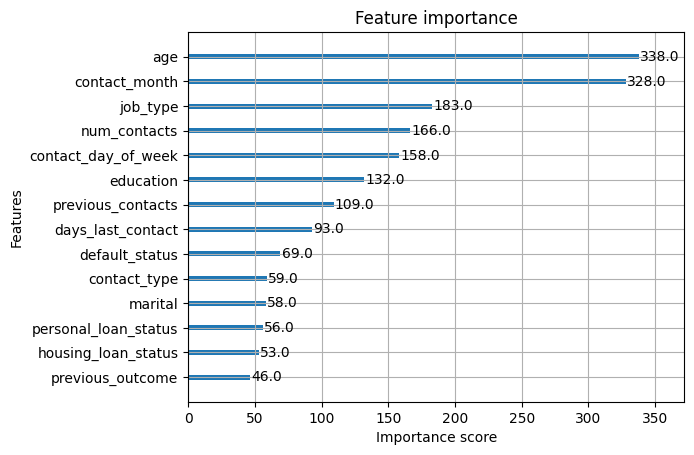

In [15]:
from xgboost import plot_importance

opt.best_estimator_.steps
xgboost_step = opt.best_estimator_.steps[1]
xgboost_model = xgboost_step[1]
plot_importance(xgboost_model)